Sine function:

GP EI versus GP dEI (winner)

https://en.wikipedia.org/wiki/Sine_and_cosine

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Sine'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Sine':
    
    # True y bounds:
    operator = 1                                  # Can toggle between seeking the synthetic's minimum versus maximum
    y_global_orig = 1                             # Maximum for y = sine(x)
        
# Constraints:
    lb = 0
    ub = 2 * np.pi 

# Input array dimension(s):
    dim = 1

# 1-D input parameter bounds:
    param = {'x1_training': ('cont', [lb, ub])}
    
    x1_test = np.linspace(lb, ub, n_test)         # Define test data object
    x_test = np.column_stack((x1_test)).T         # Transposed for algebraic reasons

    def f_syn_polarity(x1_training):              # Define synthetic function
        return  operator * np.sin(x1_training)
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seed:

seed = 1


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = 1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval. \t Proposed x \t  Current Sine y \t  Best Sine y \t          GP EI: maximum y'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval. \t Proposed x \t  Current Sine y \t  Best Sine y \t          GP dEI: maximum y'
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Plot approximate Gaussian gradients' surrogate + acquisition: y = sine(x):

def plot_Approx(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std
    colours = ['Post', 'Random']
    a = np.array([gpgo.acqfuncApprox(np.atleast_1d(x))[0] for x in x_test]).flatten()
    if new:
        fig = plt.figure(figsize=(10,7))
        r = fig.add_subplot(2, 1, 1)
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Function evaluation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        plt.ylim(-2, 2)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * f_syn_polarity(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='GP posterior mean: $\hat{y} = \mu_{GP}(\mathbf{x})$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\mu_{GP}(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', ls = '--', label='GP EI: arg min $\mathbf{x}$')
        plt.axvline(x=1.575, color='Blue', ls = '-')
        plt.legend(loc=0)
        title = 'GP EI, optimised with approximate GP EI gradients'
        r.set_title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), $\hat{\mu}_{GP}(\mathbf{x})$")
        r = fig.add_subplot(2, 1, 2)
        plt.plot(x_test, a, color='Purple', label='GP EI $(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', ls = '--', label='GP EI: arg min $\mathbf{x}$')
        plt.axvline(x=1.57, color='Blue', ls = '-', label='Sine: $\mathbf{x^{*}}$')
        plt.legend(loc=0)
        plt.xlim(0,2 * np.pi)
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("GP EI $(\mathbf{x})$")
        plt.show()
        

In [14]:
### Plot exact Gaussian gradients' surrogate + acquisition: y = sine(x):

def plot_Exact(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    x_test_h = x_test + eps
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std###y_hat - 3.182 * std, y_hat + 3.182 * std # t-score, 3 DF, 95% confidence (two-tail)
    a = np.array([gpgo.acqfuncExact(np.atleast_1d(x))[0] for x in x_test]).flatten()
    colours = ['Post', 'Random']
    if new:
        fig = plt.figure(figsize=(10,7))
        r = fig.add_subplot(2, 1, 1)
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Function evaluation point: ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialisation point: ($\mathbf{x}$, $y$)')
        plt.ylim(-3, 3)
        plt.xlim(0,2 * np.pi)
        plt.plot(x_test.flatten(), operator * f_syn_polarity(x_test.flatten()), color = 'Yellow', label='Objective function: $y$ = sin($\mathbf{x}$)')
        plt.plot(x_test.flatten(), y_hat, color = 'Orange', ls = '--', label='GP dEI posterior mean: $\hat{y} = \mu_{GP}(\mathbf{x})$')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% Confidence Interval for $\mu_{GP}(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', label='GP dEI: arg min $\mathbf{x}$')
        plt.axvline(x=1.575, color='Blue', ls = '-')
        plt.legend(loc=0)
        title = 'GP EI, optimised with exact GP dEI gradients'
        r.set_title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$), $\hat{\mu}_{STP}(\mathbf{x})$")
        r = fig.add_subplot(2, 1, 2)
        plt.plot(x_test, a, color='Purple', ls = '--', label='GP dEI $(\mathbf{x})$')
        plt.axvline(x=x_test[np.argmin(a)], color='Brown', label='GP dEI: arg min $\mathbf{x}$')
        plt.axvline(x=1.57, color='Blue', ls = '-', label='Sine: $\mathbf{x^{*}}$')
        plt.legend(loc=4)
        plt.xlim(0,2 * np.pi)
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("GP dEI $(\mathbf{x})$")
        plt.show()


In [15]:
### Approximate GP EI gradients: Sine 1st function evaluation

n_init = 3
iters = 2

np.random.seed(seed)
surrogate_approx_gp1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_gp1 = GPGO_approx(surrogate_approx_gp1, Acquisition_grad(util), f_syn_polarity, param)
approx_gp1.run(init_evals=n_init, max_iter=iters)


Eval. 	 Proposed x 	  Current Sine y 	  Best Sine y 	          GP EI: maximum y
init	 [2.62022653]	 0.4980652197092493	 0.4980652197092493	    
init	 [4.52593227]	 -0.9826672516685445	 0.4980652197092493	    
init	 [0.00071864]	 0.0007186381099970609	 0.4980652197092493	    
1	 [2.62022678]	 0.49806500621809613	 0.4980652197092493	 0.11382300242466162
2	 [2.32527703]	 0.7286273108599018	 0.7286273108599018	 0.11876715637615072


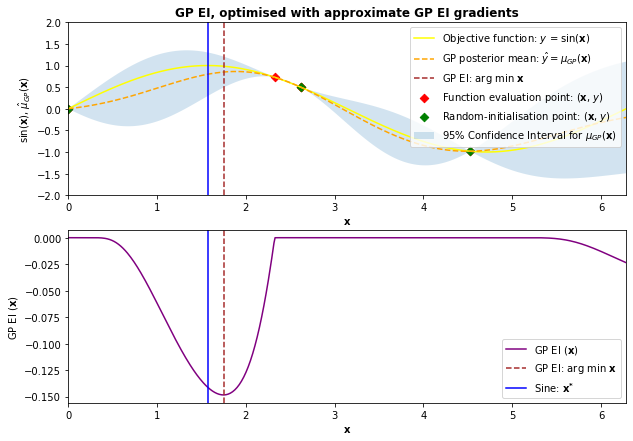

In [16]:
plot_Approx(approx_gp1, param, new=True)


In [17]:
### Approximate GP EI gradients: Sine 2nd function evaluation

np.random.seed(seed)
surrogate_approx_gp2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_gp2 = GPGO_approx(surrogate_approx_gp2, Acquisition_grad(util), f_syn_polarity, param)
approx_gp2.run(init_evals=n_init, max_iter=iters+1)


Eval. 	 Proposed x 	  Current Sine y 	  Best Sine y 	          GP EI: maximum y
init	 [2.62022653]	 0.4980652197092493	 0.4980652197092493	    
init	 [4.52593227]	 -0.9826672516685445	 0.4980652197092493	    
init	 [0.00071864]	 0.0007186381099970609	 0.4980652197092493	    
1	 [2.62022678]	 0.49806500621809613	 0.4980652197092493	 0.11382300242466162
2	 [2.32527703]	 0.7286273108599018	 0.7286273108599018	 0.11876715637615072
3	 [1.74879877]	 0.9841993522625763	 0.9841993522625763	 0.14845403687667239


In [18]:
### Exact GP dEI gradients: Sine 1st function evaluation

np.random.seed(seed)
surrogate_exact_gp1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_gp1 = GPGO_exact(surrogate_exact_gp1, Acquisition_grad(util), f_syn_polarity, param)
exact_gp1.run(init_evals=n_init, max_iter=iters)


Eval. 	 Proposed x 	  Current Sine y 	  Best Sine y 	          GP dEI: maximum y
init	 [2.62022653]	 0.4980652197092493	 0.4980652197092493	    
init	 [4.52593227]	 -0.9826672516685445	 0.4980652197092493	    
init	 [0.00071864]	 0.0007186381099970609	 0.4980652197092493	    
1	 [2.62022585]	 0.4980658126604653	 0.4980658126604653	 0.11382300242453725
2	 [2.28710499]	 0.7542346135483549	 0.7542346135483549	 0.11876815218940713


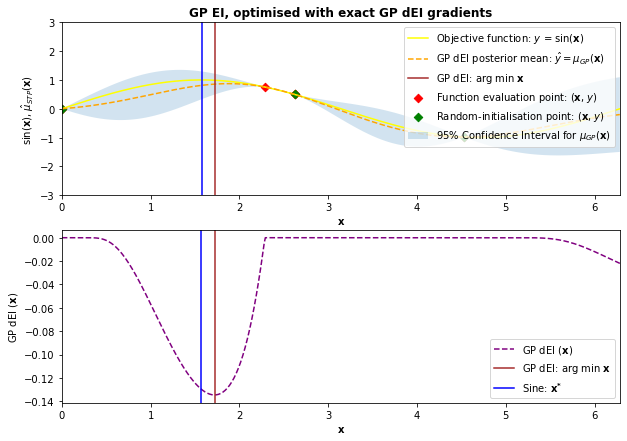

In [19]:
plot_Exact(exact_gp1, param, new=True)


In [20]:
### Exact GP dEI gradients: Sine 2nd function evaluation

np.random.seed(seed)
surrogate_exact_gp2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_gp2 = GPGO_exact(surrogate_exact_gp2, Acquisition_grad(util), f_syn_polarity, param)
exact_gp2.run(init_evals=n_init, max_iter=iters+1)


Eval. 	 Proposed x 	  Current Sine y 	  Best Sine y 	          GP dEI: maximum y
init	 [2.62022653]	 0.4980652197092493	 0.4980652197092493	    
init	 [4.52593227]	 -0.9826672516685445	 0.4980652197092493	    
init	 [0.00071864]	 0.0007186381099970609	 0.4980652197092493	    
1	 [2.62022585]	 0.4980658126604653	 0.4980658126604653	 0.11382300242453725
2	 [2.28710499]	 0.7542346135483549	 0.7542346135483549	 0.11876815218940713
3	 [1.71910318]	 0.9890226806826237	 0.9890226806826237	 0.13459053178639135
